In [1]:
# Install required package
!pip install langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.2/410.2 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.23
    Uninstalling langsmith-0.3.23:
      Successfully uninstalled langsmith-0.3.23
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.50
    Uninstalling langchain-core-0.3.50:
      Successfully uninstalled langchain-core-0.3.50
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-text-splitters 0.3.7 requires langchain-core<1.0.0,>=0.3.45, but you have langchain-core 1.0.5 which is incompatible.
langchain 0.3.22 requires langchain-core<1.0.0,>=0.3.49, but you have langchain-core 1.0.5 which is i

In [2]:
# Standard library
import os
import json
import random
import re
import warnings
from pathlib import Path
from typing import List, Literal, Optional, Union, Set, Tuple, Dict

# Scientific & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
import contextlib
import io

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.models.efficientnet import efficientnet_b0, EfficientNet_B0_Weights

# Albumentations
import albumentations as album
from albumentations.pytorch import ToTensorV2

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# LangChain & related tools
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.runnables import Runnable

import os
import json
from typing import Dict, List, Optional, Tuple
import torch
import torch.nn.functional as F
from sentence_transformers import util
from langchain_core.messages import HumanMessage

# Pydantic
from pydantic import BaseModel, Field

# Misc cleanup
warnings.filterwarnings("ignore")

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

from sentence_transformers import SentenceTransformer, util
# Load SentenceTransformer model once globally
model = SentenceTransformer('all-MiniLM-L6-v2', device=DEVICE)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-11-17 08:31:06.401456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763368266.704762      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763368266.800762      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cpu


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
GROQ_API_KEY=""
llm = ChatGroq(temperature=0, model="meta-llama/llama-4-maverick-17b-128e-instruct", api_key=GROQ_API_KEY)

In [8]:
system_prompt = """You are a medical AI assistant that extracts a **pipeline** of image analysis tasks from a user's natural language prompt.

Available targets from weights: {available_targets}

When normalizing target names, use only these exact values from the list above when possible.
If not directly matching, apply your domain knowledge to map to the most appropriate known target.

You MUST return a structured list of tasks in order of execution. For each task:

- `intent`: either "segmentation" or "classification"
- `target`: the object or condition being analyzed (e.g. "tuberculosis", "lungopacity")
- `modality`: the imaging type (e.g. "CXR", "CT", "MRI")
- `S`: set to 1 if segmentation, 0 if classification
- `weight_name`: match based on best-fit from available weights (see below)
- `dependency`: if this task must occur after another, point to the `task_id` of the prerequisite task
- `condition_on`: if this task is conditionally executed based on a prior task, provide:
    - `task_id`: ID of the prior task
    - `expected_result`: normalized outcome that triggers this task
        - For classification: use target class names like "covid"
        - For segmentation: use the target name like "opacity", "tumor", etc.
        -When specifying a condition, explicitly state whether the task should execute on:
                - For **positive results** (e.g., disease detected):
                   - Use `expected_result: covid`, `Execution: Positive`
                - For **negative results** (e.g., disease not detected): 
                   -Use `expected_result: not_covid`, `Execution: Negative`
-Suppose a task depends on another task's target **not occurring**, e.g., covid **not present**, then it will be:
        - expected_result: not_covid
        - Execution: Negative
-Suppose a task depends on another task's target **occurring**, e.g., covid **present**, then it will be:
        - expected_result: covid
        - Execution: Positive





If classification is requested:
- Infer or extract the number of classes (`num_classes`)
- Provide class names and `class_map` (e.g. {{ "0": "Normal", "1": "TB" }})

Normalize target names and modalities consistently across tasks.


---

## 🔍 How to select weights:

### ✅ 1. If user asks for multiple conditions (e.g., "Covid / TB"):
- Use a **single multiclass weight** if one matches all requested targets
- Otherwise, use **independent binary weights** for each target

### ✅ 2. If user says "identify all diseases from X-ray":
- Collect **all available classification weights** that match the given modality (e.g. "CXR")
- Use one classification task **per weight**, even if overlapping
- Prefer **multiclass weights** that cover more targets in fewer tasks
- Suppose from the weights you see that different weights like Class_TB-Covid-Pneumonia_CXR.pth and Class_LungOpacity_CXR.pth. So from CXR can detect Covid, Tuberculosis, Pneumonia, Lung Opacity. Then you need to check for everything.

---

## 📦 Available Weights:
{weights_list}

---

## ✅ Examples:

User: "Does this chest X-ray show TB?"
Output:
{{
  "pipeline": [
    {{
      "intent": "classification",
      "target": "tuberculosis",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Normal", "TB"],
      "class_map": {{"0": "Normal", "1": "TB"}}
    }}
  ]
}}

---

User: "Segment the lungs. Then, if opacity is detected, classify if it's viral or bacterial pneumonia."
Output:
{{
  "pipeline": [
    {{
      "intent": "segmentation",
      "target": "lung",
      "modality": "CXR",
      "S": 1,
      "weight_name": "Seg_Lung_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["background", "lung"],
      "class_map": {{"0": "background", "1": "lung"}}
    }},
    {{
      "intent": "segmentation",
      "target": "lungopacity",
      "modality": "CXR",
      "S": 1,
      "weight_name": "Seg_LungOpacity_CXR.pth",
      "dependency": 0,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["background", "lungopacity"],
      "class_map": {{"0": "background", "1": "lungopacity"}}
    }},
    {{
      "intent": "classification",
      "target": "pneumonia",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_Viral-Bacterial_CXR.pth",
      "dependency": 1,
      "condition_on": {{
        "task_id": 1,
        "expected_result": "lungopacity"
        "Execution":"Positive"
      }},
      "num_classes": 2,
      "class_names": ["bacterial", "viral"],
      "class_map": {{"0": "bacterial", "1": "viral"}}
    }}
  ]
}}

---

User: "Check if this patient has COVID. If not, test for TB."
Output:
{{
  "pipeline": [
    {{
      "intent": "classification",
      "target": "covid",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_COVID_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Negative", "COVID"],
      "class_map": {{"0": "Negative", "1": "COVID"}}
    }},
    {{
      "intent": "classification",
      "target": "tuberculosis",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": 0,
      "condition_on": {{
        "task_id": 0,
        "expected_result": "not_covid"
        "Execution":"Negative"
      }},
      "num_classes": 2,
      "class_names": ["Normal", "TB"],
      "class_map": {{"0": "Normal", "1": "TB"}}
    }}
  ]
}}

---

User: "Check if this patient has COVID. If yes, test for TB."
Output:
{{
  "pipeline": [
    {{
      "intent": "classification",
      "target": "covid",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_COVID_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Negative", "COVID"],
      "class_map": {{"0": "Negative", "1": "COVID"}}
    }},
    {{
      "intent": "classification",
      "target": "tuberculosis",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": 0,
      "condition_on": {{
        "task_id": 0,
        "expected_result": "covid"
        "Execution":"Positive"
      }},
      "num_classes": 2,
      "class_names": ["Normal", "TB"],
      "class_map": {{"0": "Normal", "1": "TB"}}
    }}
  ]
}}

-----

User: "Check for Covid or TB."
Output:
{{
  "pipeline": [
    {{
      "intent": "classification",
      "target": "covid",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_COVID_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Negative", "COVID"],
      "class_map": {{"0": "Negative", "1": "COVID"}}
    }},
    {{
      "intent": "classification",
      "target": "tuberculosis",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Normal", "TB"],
      "class_map": {{"0": "Normal", "1": "TB"}}
    }}
  ]
}}

---

User: "Identify all diseases from this chest X-ray."
Output:
{{
  "pipeline": [
    {{
      "intent": "classification",
      "target": "tuberculosis",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Normal", "TB"],
      "class_map": {{"0": "Normal", "1": "TB"}}
    }},
    {{
      "intent": "classification",
      "target": "covid",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_COVID_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Negative", "COVID"],
      "class_map": {{"0": "Negative", "1": "COVID"}}
    }},
    {{
      "intent": "classification",
      "target": "pneumonia",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_Pneumonia_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": ["Normal", "Pneumonia"],
      "class_map": {{"0": "Normal", "1": "Pneumonia"}}
    }}
  ]
}}

---

User: "Isolate lungs by segmentation, then classify TB only on segmented lungs."
Output:
{{
  "pipeline": [
    {{
      "intent": "segmentation",
      "target": "lung",
      "modality": "CXR",
      "S": 1,
      "weight_name": "Seg_Lung_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "background",
        "lung"
      ],
      "class_map": {{
        "0": "background",
        "1": "lung"
      }}
    }},
    {{
      "intent": "classification",
      "target": "tb",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": 0,
      "condition_on": {{
        "task_id": 0,
        "expected_result": "positive"
      }},
      "num_classes": 2,
      "class_names": [
        "Normal",
        "Tb"
      ],
      "class_map": {{
        "0": "Normal",
        "1": "TB"
      }}
    }}
  ]
}}

---

User: "Segment lung, then classify for TB only if pneumonia is detected."
Output:
{{
  "pipeline": [
    {{
      "intent": "segmentation",
      "target": "lung",
      "modality": "CXR",
      "S": 1,
      "weight_name": "Seg_Lung_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "background",
        "lung"
      ],
      "class_map": {{
        "0": "background",
        "1": "lung"
      }}
    }},
    {{
      "intent": "classification",
      "target": "pneumonia",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_Pneumonia_CXR.pth",
      "dependency": 0,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "Normal",
        "Pneumonia"
      ],
      "class_map": {{
        "0": "Normal",
        "1": "Pneumonia"
      }}
    }},
    {{
      "intent": "classification",
      "target": "tb",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": 1,
      "condition_on": {{
        "task_id": 1,
        "expected_result": "pneumonia"
        "Execution":"Positive"
      }},
      "num_classes": 2,
      "class_names": [
        "Normal",
        "TB"
      ],
      "class_map": {{
        "0": "Normal",
        "1": "TB"
      }}
    }}
  ]
}}


---

User: "Segment lung, then classify for TB only if pneumonia is not detected."
Output:
{{
  "pipeline": [
    {{
      "intent": "segmentation",
      "target": "lung",
      "modality": "CXR",
      "S": 1,
      "weight_name": "Seg_Lung_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "background",
        "lung"
      ],
      "class_map": {{
        "0": "background",
        "1": "lung"
      }}
    }},
    {{
      "intent": "classification",
      "target": "pneumonia",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_Pneumonia_CXR.pth",
      "dependency": 0,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "Normal",
        "Pneumonia"
      ],
      "class_map": {{
        "0": "Normal",
        "1": "Pneumonia"
      }}
    }},
    {{
      "intent": "classification",
      "target": "tb",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_TB_CXR.pth",
      "dependency": 1,
      "condition_on": {{
        "task_id": 1,
        "expected_result": "not_pneumonia"
        "Execution":"Negative"
      }},
      "num_classes": 2,
      "class_names": [
        "Normal",
        "TB"
      ],
      "class_map": {{
        "0": "Normal",
        "1": "TB"
      }}
    }}
  ]
}}

-----

Respond ONLY in JSON using this schema:
{{ 
  "pipeline": [
    {{ 
      "intent": "...", 
      "target": "...", 
      "modality": "...", 
      "S": 0/1, 
      "weight_name": "...", 
      "dependency": null/int, 
      "condition_on": null/object,
      "num_classes": int,
      "class_names": [...],
      "class_map": {{...}}
    }}
  ] 
}}"""


In [9]:
# --- Utility to Get Available Weights ---
def get_available_weights(weight_dir: str = "/kaggle/input/trained-weights") -> Set[Tuple[str, str, str, str]]:
    weight_files = os.listdir(weight_dir)
    valid_weights = set()

    for file in weight_files:
        if file.endswith(".pth"):
            base = file.replace(".pth", "")
            parts = base.split("_")
            if len(parts) >= 3:
                intent_raw, target, modality = parts[0], parts[1], parts[2]
                intent = "classification" if "class" in intent_raw.lower() else "segmentation"
                valid_weights.add((intent, target.lower(), modality.upper(), file))
    return valid_weights


# --- Models ---
class TaskCondition(BaseModel):
    task_id: int
    expected_result: Optional[str] = None
    Execution: Literal["Positive", "Negative"] = "Positive"  # New field with default value

class MedicalTask(BaseModel):
    intent: str
    target: str
    modality: str
    S: Optional[int] = Field(default=None)
    weight_name: Optional[str] = Field(default=None)
    dependency: Optional[int] = Field(default=None)
    condition_on: Optional[TaskCondition] = Field(default=None)

    # Class information
    num_classes: Optional[int] = None
    class_names: Optional[List[str]] = None
    class_map: Optional[Dict[str, str]] = None  # Keys must be str for JSON compatibility


class MedicalPipeline(BaseModel):
    pipeline: List[MedicalTask]


# --- Parser ---
parser = PydanticOutputParser(pydantic_object=MedicalPipeline)

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{input}")
])


# --- Define the chain (assume llm is defined elsewhere) ---
# Replace 'llm' with your actual LLM instance
chain: Runnable = prompt | llm | parser


# --- Helper Functions ---

def parse_class_names_from_filename(filename: str, weight_dir: str = "/kaggle/input/trained-weights") -> List[str]:
    """Try to load external class mapping file first, fall back to parsing filename."""
    base = filename.replace(".pth", "")
    mapping_path = os.path.join(weight_dir, f"{base}_classes.json")

    if os.path.exists(mapping_path):
        with open(mapping_path, "r") as f:
            data = json.load(f)
            return data.get("classes", [])

    # Fallback to parsing from filename
    parts = base.split("_")
    if len(parts) < 3:
        return []

    target_part = parts[1]
    if "-" in target_part:
        return [cls.strip().replace(" ", " ") for cls in target_part.split("-")]
    return ["Normal", target_part.title()]

class Normalizer:
    def __init__(self, llm=None):
        # Basic dictionary mappings for target and modality
        self.target_map = {
            "tuberculosis": "tb",
            "tb": "tb",
            "covid-19": "covid",
            "covid": "covid",
            "corona": "covid",
            "coronavirus": "covid",
            # Add more common mappings here as needed
        }
        
        self.modality_map = {
            "chest x-ray": "CXR",
            "x-ray": "CXR",
            "radiograph": "CXR",
            "computed tomography": "CT",
            "ct": "CT",
            "magnetic resonance": "MRI",
            "mri": "MRI",
            "color fundus photography": "CFP",
            "cfp": "CFP",
            "pet": "PET",
            "ultrasound": "ULTRASOUND",
            # Add more modality mappings as needed
        }
        
        self.suffix_pattern = re.compile(
            r"-(pneumonia|lungopacity|viralpneumonia|normal|healthy)$", 
            re.IGNORECASE
        )
        
        self.llm = llm  # Your LLM instance, e.g., ChatGroq
        
        # Simple caches for LLM results (avoid repeated calls)
        self._target_llm_cache: Dict[str, str] = {}
        self._modality_llm_cache: Dict[str, str] = {}

    def normalize_target(self, target: str) -> str:
        if not target:
            return ""
        t = target.lower().strip()

        # Direct dictionary mapping
        if t in self.target_map:
            return self.target_map[t]

        # Remove suffix if present
        t_nosuffix = self.suffix_pattern.sub("", t)
        if t_nosuffix in self.target_map:
            return self.target_map[t_nosuffix]

        # Partial substring match
        for k, v in self.target_map.items():
            if k in t_nosuffix:
                return v
        
        # Try LLM fallback if available
        if self.llm:
            if t not in self._target_llm_cache:
                try:
                    prompt = f"Normalize this medical imaging target label: '{target}'. Provide a short canonical target keyword."
                    #response = self.llm.chat(prompt)
                    response = self.llm.invoke(prompt)
                    norm_target = response.get('content', '').strip().lower()
                    norm_target = norm_target.split()[0] if norm_target else t
                    self._target_llm_cache[t] = norm_target
                except Exception as e:
                    print(f"LLM normalization error for target '{target}': {e}")
                    self._target_llm_cache[t] = t
            return self._target_llm_cache[t]

        # Fallback: return lowercase cleaned string
        return t_nosuffix

    def normalize_modality(self, modality: str) -> str:
        if not modality:
            return ""
        m = modality.lower().strip()

        # Dictionary mapping first
        if m in self.modality_map:
            return self.modality_map[m]

        # Try LLM fallback if available
        if self.llm:
            if m not in self._modality_llm_cache:
                try:
                    prompt = f"Normalize this medical imaging modality label: '{modality}'. Provide the canonical uppercase abbreviation (e.g., CXR, CT, MRI)."
                    #response = self.llm.chat(prompt)
                    response = self.llm.invoke(prompt)
                    norm_mod = response.get('content', '').strip().upper()
                    if not norm_mod or len(norm_mod) > 6:
                        norm_mod = modality.upper()
                    self._modality_llm_cache[m] = norm_mod
                except Exception as e:
                    print(f"LLM normalization error for modality '{modality}': {e}")
                    self._modality_llm_cache[m] = modality.upper()
            return self._modality_llm_cache[m]

        # Fallback: uppercase original
        return modality.upper()

    def normalize_expected_result(self, expected_result: Optional[str]) -> Optional[str]:
        if not expected_result:
           return None
        result = expected_result.lower().strip()
    # Handle negation patterns
        if result.startswith("not_"):
            base = result[4:]
            normalized_base = self.normalize_target(base)
            return f"not_{normalized_base}"
        else:
            return self.normalize_target(result)


normalizer = Normalizer(llm=llm)


def get_available_weights(weight_dir: str = "/kaggle/input/trained-weights") -> List[Tuple[str, str, str, str]]:
    weight_files = os.listdir(weight_dir)
    valid_weights = []
    for file in weight_files:
        if file.endswith(".pth"):
            base = file.replace(".pth", "")
            parts = base.split("_")
            if len(parts) >= 3:
                intent_raw, target, modality = parts[0], parts[1], parts[2]
                intent = "classification" if "class" in intent_raw.lower() else "segmentation"
                valid_weights.append((intent, target.lower(), modality.upper(), file))
    return valid_weights


def score_weight(w_intent, w_target, w_modality, task):
    score = 0.0

    task_intent = task["intent"]
    task_target = task["target"]
    task_modality = task["modality"]

    # Intent match (fast early reject)
    if w_intent != task_intent:
        return 0.0
    score += 1.0

    # Semantic target similarity
    sim_target = semantic_similarity(w_target, task_target)
    score += sim_target * 1.5  # max 1.5 points from semantic match

    # Semantic modality similarity
    sim_modality = semantic_similarity(w_modality, task_modality)
    score += sim_modality * 1.0  # max 1 point from modality

    return round(score, 3)

def extract_pipeline(input_text: str, weight_dir: str = "/kaggle/input/trained-weights") -> dict:
    available_weights = get_available_weights(weight_dir)
    weights_list = [f"{intent} {target} ({modality}) → {fname}" for intent, target, modality, fname in available_weights]
    unique_targets = sorted(set(w[1] for w in available_weights))
    targets_str = ", ".join(unique_targets)

    try:
        result = chain.invoke({
            "input": input_text,
            "weights_list": "\n".join(weights_list),
            "available_targets": targets_str
        })
    except OutputParserException as e:
        print("🚨 Failed to parse LLM output:")
        print(e.llm_output)
        raise

    result_dict = result.dict()
    pipeline = result_dict["pipeline"]

    # Normalize task fields upfront
    for i, task in enumerate(pipeline):
        task["S"] = 1 if task["intent"] == "segmentation" else 0
        task["target"] = normalizer.normalize_target(task["target"])
        task["modality"] = normalizer.normalize_modality(task["modality"])
        task["dependency"] = i - 1 if i > 0 else None

        if task.get("condition_on") is None:
            task["condition_on"] = None
        else:
            cond = task["condition_on"]
            if isinstance(cond, dict):
                cond_task = pipeline[cond["task_id"]]
                expected_result = cond.get("expected_result")
                reason = cond.get("reason", "").lower()  # Optional field from LLM

                # Detect negation cues
                negation_detected = any(
                    phrase in reason for phrase in [
                        "not present", "is not", "does not", "absent", "no presence",
                        "no evidence", "free of", "without", "negative for"
                    ]
                )

                if cond_task["intent"] == "segmentation":
                    cond["expected_result"] = "positive"
                    cond["Execution"] = "Negative" if negation_detected else "Positive"
                else:
                    if expected_result is None:
                        expected_result = cond_task["target"]

                    normalized_result = normalizer.normalize_expected_result(expected_result)

                    # Handle not_ prefix explicitly
                    if normalized_result.startswith("not_"):
                        cond["expected_result"] = normalized_result
                        cond["Execution"] = "Negative"
                    else:
                        cond["expected_result"] = normalized_result
                        cond["Execution"] = "Negative" if negation_detected else "Positive"

    # Prepare embedding inputs (normalized)
    weight_targets = [w[1] for w in available_weights]
    weight_modalities = [w[2] for w in available_weights]
    task_targets = [task["target"] for task in pipeline]
    task_modalities = [task["modality"] for task in pipeline]

    # Normalize embeddings to ensure cosine similarity in [-1,1]
    emb_targets_weights = F.normalize(model.encode(weight_targets, convert_to_tensor=True, device=DEVICE), p=2, dim=1)
    emb_modalities_weights = F.normalize(model.encode(weight_modalities, convert_to_tensor=True, device=DEVICE), p=2, dim=1)

    emb_targets_tasks = F.normalize(model.encode(task_targets, convert_to_tensor=True, device=DEVICE), p=2, dim=1)
    emb_modalities_tasks = F.normalize(model.encode(task_modalities, convert_to_tensor=True, device=DEVICE), p=2, dim=1)

    # Compute similarity matrices (W x T)
    sim_targets = util.pytorch_cos_sim(emb_targets_weights, emb_targets_tasks)  # shape (W, T)
    sim_modalities = util.pytorch_cos_sim(emb_modalities_weights, emb_modalities_tasks)  # shape (W, T)

    # Quick access lists
    weight_intents = [w[0] for w in available_weights]
    weight_fnames = [w[3] for w in available_weights]

    SCORE_THRESHOLD = 1.8

    # For each task, select best weight
    for t_idx, task in enumerate(pipeline):
        scores = []
        fnames = []
        target_lower = task["target"].lower()

        for w_idx, w_intent in enumerate(weight_intents):
            fname = weight_fnames[w_idx]

            if w_intent != task["intent"]:
                continue

            is_segclass_weight = "SegClass" in fname
            has_condition = task.get("condition_on") is not None

            # Strict SegClass filter: must have condition AND target match
            if is_segclass_weight:
                if not has_condition:
                    continue
                if target_lower not in fname.lower():
                    continue

            # Skip regular classification models if a condition exists
            elif has_condition and not is_segclass_weight:
                pass

            score = 1.0 + sim_targets[w_idx, t_idx].item() * 1.5 + sim_modalities[w_idx, t_idx].item() * 1.0
            scores.append(score)
            fnames.append(fname)

        if scores:
            # Prefer weights that contain the target name in filename
            matching = [(s, f) for s, f in zip(scores, fnames) if target_lower in f.lower()]
            non_matching = [(s, f) for s, f in zip(scores, fnames) if target_lower not in f.lower()]

            if matching:
                best_score, best_weight = max(matching, key=lambda x: x[0])
            else:
                best_score, best_weight = max(zip(scores, fnames), key=lambda x: x[0])

            best_score = round(best_score, 3)

            if best_score < SCORE_THRESHOLD:
                best_weight = None
                best_score = None
        else:
            best_weight = None
            best_score = None

        task["weight_name"] = best_weight
        task["match_score"] = best_score

        # Assign class info if suitable weight found
        if best_weight:
            class_names = parse_class_names_from_filename(best_weight, weight_dir)
            if task["intent"] == "classification":
                sorted_class_names = sorted(class_names)
                task["num_classes"] = len(sorted_class_names)
                task["class_names"] = sorted_class_names
                task["class_map"] = {str(i): cls for i, cls in enumerate(sorted_class_names)}
            elif task["intent"] == "segmentation":
                task["num_classes"] = 2
                task["class_names"] = ["background", task["target"].lower()]
                task["class_map"] = {"0": "background", "1": task["target"].lower()}
        else:
            task["num_classes"] = None
            task["class_names"] = None
            task["class_map"] = None

    print(json.dumps(result_dict, indent=2))
    return result_dict

In [10]:
extract_pipeline("If the patient has glaucoma, then segment the Optic Cup")

LLM normalization error for target 'glaucoma': 'AIMessage' object has no attribute 'get'
LLM normalization error for modality 'COLORFUNDUS': 'AIMessage' object has no attribute 'get'
LLM normalization error for target 'opticcup': 'AIMessage' object has no attribute 'get'


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "pipeline": [
    {
      "intent": "classification",
      "target": "glaucoma",
      "modality": "COLORFUNDUS",
      "S": 0,
      "weight_name": "Class_Glaucoma_ColorFundus.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "Glaucoma",
        "Normal"
      ],
      "class_map": {
        "0": "Glaucoma",
        "1": "Normal"
      },
      "match_score": 3.5
    },
    {
      "intent": "segmentation",
      "target": "opticcup",
      "modality": "COLORFUNDUS",
      "S": 1,
      "weight_name": "Seg_OpticCup_ColorFundus.pth",
      "dependency": 0,
      "condition_on": {
        "task_id": 0,
        "expected_result": "glaucoma",
        "Execution": "Positive"
      },
      "num_classes": 2,
      "class_names": [
        "background",
        "opticcup"
      ],
      "class_map": {
        "0": "background",
        "1": "opticcup"
      },
      "match_score": 3.5
    }
  ]
}


{'pipeline': [{'intent': 'classification',
   'target': 'glaucoma',
   'modality': 'COLORFUNDUS',
   'S': 0,
   'weight_name': 'Class_Glaucoma_ColorFundus.pth',
   'dependency': None,
   'condition_on': None,
   'num_classes': 2,
   'class_names': ['Glaucoma', 'Normal'],
   'class_map': {'0': 'Glaucoma', '1': 'Normal'},
   'match_score': 3.5},
  {'intent': 'segmentation',
   'target': 'opticcup',
   'modality': 'COLORFUNDUS',
   'S': 1,
   'weight_name': 'Seg_OpticCup_ColorFundus.pth',
   'dependency': 0,
   'condition_on': {'task_id': 0,
    'expected_result': 'glaucoma',
    'Execution': 'Positive'},
   'num_classes': 2,
   'class_names': ['background', 'opticcup'],
   'class_map': {'0': 'background', '1': 'opticcup'},
   'match_score': 3.5}]}

# CNN

In [11]:
# SeparableConv2d remains unchanged
class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, dilation=1, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

# ASPP remains unchanged
class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels, atrous_rates):
        super().__init__()
        modules = [
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        ]
        for rate in atrous_rates:
            modules.append(nn.Sequential(
                SeparableConv2d(in_channels, out_channels, 3, padding=rate, dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))
        modules.append(nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ))
        self.convs = nn.ModuleList(modules)
        self.project = nn.Sequential(
            nn.Conv2d((len(atrous_rates) + 2) * out_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5)
        )

    def forward(self, x):
        size = x.shape[2:]
        res = [F.interpolate(conv(x), size=size, mode='bilinear', align_corners=True) if i == len(self.convs)-1 else conv(x) for i, conv in enumerate(self.convs)]
        return self.project(torch.cat(res, dim=1))

# MFF Block
class MFFBlock(nn.Module):
    def __init__(self, in_channels_low, in_channels_high, out_channels):
        super().__init__()
        self.low_proj = nn.Conv2d(in_channels_low, out_channels, 1, bias=False)
        self.high_proj = nn.Conv2d(in_channels_high, out_channels, 1, bias=False)
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 8, 1),
            nn.ReLU(),
            nn.Conv2d(out_channels // 8, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, low_feat, high_feat):
        high_feat = F.interpolate(high_feat, size=low_feat.shape[2:], mode='bilinear', align_corners=True)
        low_feat = self.low_proj(low_feat)
        high_feat = self.high_proj(high_feat)
        x = low_feat + high_feat
        x = self.fusion(x)
        return x * self.se(x)

# CAFSE Block
class CAFSEBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.coarse = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        self.fine = nn.Sequential(
            nn.Conv2d(channels, channels, 1),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )

    def forward(self, decoder_feat, aspp_feat):
        aspp_feat = F.interpolate(aspp_feat, size=decoder_feat.shape[2:], mode='bilinear', align_corners=True)
        coarse = self.coarse(aspp_feat)
        fine = self.fine(decoder_feat)
        return decoder_feat + coarse * fine

# Decoder remains unchanged
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.fuse = nn.Sequential(
            SeparableConv2d(96, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            SeparableConv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )

    def forward(self, x, low_level_feat):
        x = F.interpolate(x, size=low_level_feat.shape[2:], mode='bilinear', align_corners=True)
        x = self.conv1(x)
        x = torch.cat([x, low_level_feat], dim=1)
        return self.fuse(x)

# Main model
class DeepLabV3Plus_EfficientNet(nn.Module):
    def __init__(self, num_classes_seg=1, num_classes_cls=2, mode=1, output_stride=16, activation='sigmoid'):
        super().__init__()
        self.mode = mode
        self.output_stride = output_stride

        backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
        features = list(backbone.features.children())
        if output_stride == 16:
            self.low_level = nn.Sequential(*features[:3])
            self.high_level = nn.Sequential(*features[3:])
        else:
            self.low_level = nn.Sequential(*features[:2])
            self.high_level = nn.Sequential(*features[2:])

        low_level_channels = 24 if output_stride == 16 else 16
        self.low_proj = nn.Sequential(
            nn.Conv2d(low_level_channels, 48, 1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        atrous_rates = [6, 12, 18] if output_stride == 16 else [12, 24, 36]
        self.aspp = ASPP(1280, 256, atrous_rates)
        self.mff = MFFBlock(48, 256, 256)
        self.decoder = Decoder(256, 256)
        self.cafse = CAFSEBlock(256)
        self.final_conv = nn.Conv2d(256, num_classes_seg, 1)

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes_cls)
        )

        if activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        elif activation == 'softmax2d':
            self.activation = nn.Softmax2d()
        else:
            self.activation = None

    def forward(self, x):
        input_size = x.size()[2:]
        low_feat = self.low_level(x)
        high_feat = self.high_level(low_feat)
        low_proj = self.low_proj(low_feat)

        if self.mode == 0:
            out = self.classifier(high_feat)
            return out
        elif self.mode == 1:
            aspp_out = self.aspp(high_feat)
            mff_out = self.mff(low_proj, aspp_out)
            decoder_out = self.decoder(mff_out, low_proj)
            cafse_out = self.cafse(decoder_out, aspp_out)
            out = self.final_conv(cafse_out)
            out = F.interpolate(out, size=input_size, mode='bilinear', align_corners=True)
            if self.activation is not None:
                out = self.activation(out)
            return out
        else:
            raise ValueError("Mode must be 0 (classification) or 1 (segmentation)")


In [12]:
def build_model_from_task(task: dict):
    if task["weight_name"] is None:
        print("No weight found for this task")
        return None  # or raise an exception depending on use case

    base_path = "/kaggle/input/trained-weights"
    weight_path = f"{base_path}/{task['weight_name']}"

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    print(f"[Model Load] Building model for task: {task['intent'].upper()} - {task['target'].upper()}")
    print(f"              Weight file: {weight_path}")
    print(f"              Num Classes: {task['num_classes']}")
    print(f"              Mode (S/C): {task['S']}")

    try:
        model = DeepLabV3Plus_EfficientNet(
            num_classes_seg=2,              # segmentation fixed at 2 classes
            num_classes_cls=task["num_classes"],  # dynamic classification classes
            mode=task["S"]
        ).to(DEVICE)

        model.load_state_dict(torch.load(weight_path, map_location=DEVICE))
        model.eval()
        return model
    except Exception as e:
        print(f"[Error] Failed to load model from {weight_path}: {e}")
        return None
        

def build_class_maps(pipeline: dict):
    cls_tasks = [task for task in pipeline["pipeline"] if task["intent"].lower() == "classification"]
    if not cls_tasks:
        raise ValueError("No classification tasks found in pipeline.")
    
    task = cls_tasks[0]

    # Prefer 'class_map' if available
    if "class_map" in task:
        # Convert string keys to integers
        idx_to_class = {int(k): v for k, v in task["class_map"].items()}
        class_to_idx = {v: k for k, v in idx_to_class.items()}
    elif "class_names" in task and task["class_names"]:
        class_names = task["class_names"]
        class_to_idx = {label: idx for idx, label in enumerate(class_names)}
        idx_to_class = {idx: label for idx, label in enumerate(class_names)}
    else:
        target = task["target"].lower()
        if target == "tb":
            class_names = ["TB", "Normal"]
        elif target == "pneumonia":
            class_names = ["Pneumonia", "Normal"]
        else:
            class_names = [task["target"].capitalize(), "Normal"]
        class_to_idx = {label: idx for idx, label in enumerate(class_names)}
        idx_to_class = {idx: label for idx, label in enumerate(class_names)}

    return class_to_idx, idx_to_class

# Classification

In [13]:
def get_cls_validation_augmentation():
    return album.Compose([
        album.PadIfNeeded(min_height=256, min_width=256,
                          border_mode=cv2.BORDER_CONSTANT, value=0)
    ])

def get_cls_preprocessing():
    def to_tensor(x, **kwargs):
        return x.transpose(2, 0, 1).astype('float32')

    return album.Compose([
        album.Resize(height=256, width=256),
        album.Lambda(image=to_tensor)
    ])

def predict_cls_single_image(image_input, model, pipeline: dict, device='cuda', is_array=False):
    """
    Predicts class of a single image using the provided model and pipeline-based class mappings.

    image_input: path or np.ndarray (RGB)
    is_array: if True, assumes image_input is already an RGB ndarray
    """
    class_to_idx, idx_to_class = build_class_maps(pipeline)

    # Load image
    if not is_array:
        image = cv2.imread(str(image_input))
        if image is None:
            raise ValueError(f"Image file not found or invalid: {image_input}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        image = image_input
        if image.ndim == 2:  # grayscale
            image = np.stack([image]*3, axis=-1)
        elif image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)

    # Resize and preprocess
    resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    val_augmentation = get_cls_validation_augmentation()
    preprocessing = get_cls_preprocessing()

    augmented = val_augmentation(image=resized_image)
    processed = preprocessing(image=augmented['image'])
    image_tensor = torch.from_numpy(processed['image']).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        if len(output.shape) > 2:
            output = output.view(output.size(0), output.size(1), -1).mean(dim=2)
        _, pred_idx = torch.max(output, 1)
        prob = torch.softmax(output, 1).cpu().numpy()[0]

    pred_label = idx_to_class[pred_idx.item()]
    confidence = prob[class_to_idx[pred_label]]

    return pred_label, float(confidence)

def run_classification_pipeline(prompt, image_input, model=None, segmented=False, pipeline=None):
    """
    Runs classification and returns either:
    - "<Disease>" if prediction matches the pipeline's target
    - "Not <Disease>" otherwise

    image_input: path (str) or np.ndarray
    segmented: if True, assumes image_input is already a pre-processed np.ndarray
    pipeline: required to map class names and get the target disease
    """
    if model is None:
        result = extract_pipeline(prompt)
        task = result["pipeline"][0]
        model = build_model_from_task(task)
        pipeline = result  # Use for class mapping
    elif pipeline is None:
        raise ValueError("pipeline argument is required to resolve class mappings.")

    # Get task info from pipeline
    task = pipeline["pipeline"][0]
    target_disease = task["target"].capitalize()  # e.g. "covid" → "Covid"
    class_names = task["class_names"]  # e.g. ["Covid", "LungOpacity", ...]

    # Build class maps
    class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
    idx_to_class = {idx: cls for idx, cls in enumerate(class_names)}

    # Load or use provided image
    if segmented:
        image = image_input
        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        elif image.shape[2] == 1:
            image = np.repeat(image, 3, axis=2)
        resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LANCZOS4)
    else:
        image = cv2.imread(str(image_input))
        if image is None:
            raise ValueError(f"Image file not found or invalid: {image_input}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(image, (256, 256), interpolation=cv2.INTER_LANCZOS4)

    # Augmentation and preprocessing
    val_augmentation = get_cls_validation_augmentation()
    preprocessing = get_cls_preprocessing()

    augmented = val_augmentation(image=resized_image)
    processed = preprocessing(image=augmented['image'])
    image_tensor = torch.from_numpy(processed['image']).unsqueeze(0).to(DEVICE)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)

        if len(output.shape) > 2:
            output = output.view(output.size(0), output.size(1), -1).mean(dim=2)

        _, pred_idx = torch.max(output, 1)
        prob = torch.softmax(output, 1).cpu().numpy()[0]

    pred_label = idx_to_class[pred_idx.item()]
    confidence = prob[class_to_idx[pred_label]]

    # Final decision based on pipeline's target
    if pred_label == target_disease:
        final_prediction = target_disease
    else:
        final_prediction = f"Not {target_disease}"

    return {
        "prompt": prompt,
        "prediction": final_prediction,
        "confidence": round(float(confidence), 4),
        "predicted_class": pred_label  # Optional metadata
    }



# Segmentation

In [14]:
# One-hot encoding and decoding
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    return np.stack(semantic_map, axis=-1)

def reverse_one_hot(image):
    return np.argmax(image, axis=-1)

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    return colour_codes[image.astype(int)]

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_seg_preprocessing():
    return album.Compose([
        album.Resize(height=256, width=256),  # Resize to 256x256
        album.Lambda(image=to_tensor, mask=to_tensor)  # Convert to tensor
    ])

def predict_mask_for_single_image(image_path, model, preprocessing_fn, target_size=(256, 256), device='cuda'):
    """
    Predicts binary segmentation mask for a single image.
    Resizes in-memory before inference.
    Returns original image and predicted grayscale mask.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image: {image_path}. File may be corrupted.")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    orig_dims = image.shape[:2]  # HxW

    # Resize in-memory
    resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # Apply preprocessing
    preprocessed = preprocessing_fn(image=resized_image)
    image_tensor = torch.from_numpy(preprocessed['image']).unsqueeze(0).to(device)

    # Inference
    model.eval()
    with torch.no_grad():
        output = model(image_tensor).cpu().numpy()

    # Post-process output
    pred_mask = np.transpose(output[0], (1, 2, 0))
    pred_mask_argmax = np.argmax(pred_mask, axis=-1)
    pred_mask_grayscale = (pred_mask_argmax > 0).astype(np.uint8) * 255

    # Resize back to original dimensions
    if pred_mask_grayscale.shape != orig_dims:
        pred_mask_grayscale = cv2.resize(
            pred_mask_grayscale,
            (orig_dims[1], orig_dims[0]),
            interpolation=cv2.INTER_NEAREST
        )

    return image, pred_mask_grayscale

In [15]:
def run_segmentation_pipeline(prompt, image_path, model=None):
    """
    Unified segmentation pipeline that:
    - Parses task from prompt
    - Loads or uses provided model
    - Predicts and returns mask
    """
    if model is None:
        print("Parsing task...")
        result = extract_pipeline(prompt)
        task = result["pipeline"][0]
        print("Loading model...")
        model = build_model_from_task(task)

    print("Running prediction...")
    image, pred_mask = predict_mask_for_single_image(
        image_path=image_path,
        model=model,
        preprocessing_fn=get_seg_preprocessing(),
        device=DEVICE
    )

    return {
        "prompt": prompt,
        "original_image": image,
        "predicted_mask": pred_mask
    }

# Combined Pipeline

In [16]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json

def run_unified_pipeline(prompt: str, image_path: str, debug: bool = False):
    """
    Unified pipeline runner for segmentation and classification tasks.
    Supports conditional execution based on previous task results:
        - Positive result (e.g., disease detected)
        - Negative result (e.g., disease not detected)

    Args:
        prompt (str): Natural language description of the imaging analysis pipeline
        image_path (str): Path to the input image file
        debug (bool): Whether to print debug information

    Returns:
        dict: Dictionary containing outputs from each executed task
    """

    print("🔍 Understanding task from prompt...")
    result = extract_pipeline(prompt)
    pipeline_tasks = result["pipeline"]

    if debug:
        import pprint
        print("📄 Pipeline Structure:")
        pprint.pprint(result)

    outputs = {}
    segmented_outputs = {}  # Stores segmented images by task index
    task_results = {}       # Stores metadata/results per task

    for idx, task in enumerate(pipeline_tasks):
        intent = task["intent"].lower()
        target = task["target"].lower()
        dependency = task.get("dependency", None)
        condition = task.get("condition_on", None)

        print(f"\n🧩 Task {idx + 1}/{len(pipeline_tasks)}: {intent.upper()} - {target.upper()}")

        # Check condition before execution
        if condition:
            required_id = condition["task_id"]
            expected_result = condition.get("expected_result", None)
            execution_type = condition.get("Execution", "Positive").capitalize()

            if expected_result:
                expected_result = expected_result.lower()

            if required_id not in task_results:
                print(f"⚠️ Skipping Task {idx}: Required result from Task {required_id} is missing.")
                continue

            actual_result = task_results[required_id]
            actual_intent = actual_result["intent"].lower()
            actual_raw = actual_result["raw"].lower()
            actual_normalized = actual_result["normalized"].lower()

            should_run = False

            if actual_intent == "segmentation":
                # Segmentation always triggers downstream tasks unless empty mask
                should_run = True
            else:
                # For classification results
                if execution_type == "Positive":
                    # Run if actual matches expected positive class
                    should_run = (
                        expected_result is None or
                        expected_result == "any" or
                        expected_result == actual_raw.lower() or
                        expected_result == actual_normalized.lower() or
                        (actual_normalized == "positive" and expected_result != "not_covid")
                    )
                elif execution_type == "Negative":
                    # Run if actual does NOT match expected class
                    should_run = (
                        expected_result is None or
                        expected_result == "none" or
                        (expected_result.startswith("not_") and not actual_raw.lower().startswith(expected_result[4:])) or
                        actual_normalized == "negative"
                    )

            if not should_run:
                print(f"⏭️ Skipping Task {idx}: Condition not met. "
                      f"(Expected {execution_type} result on '{expected_result}', "
                      f"got intent='{actual_intent}', raw='{actual_raw}', normalized='{actual_normalized}')")
                continue
            else:
                print(f"✅ Proceeding with Task {idx}: Condition met.")

        # Check weight is assigned before proceeding
        if not task.get("weight_name"):
            print(f"⚠️ No weight assigned for Task {idx}: Skipping this task.")
            continue

        print("🔄 Loading model...")
        model = build_model_from_task(task)

        if intent == "segmentation":
            if model is None:
                print(f"⚠️ Skipping Task {idx}: No suitable model found for segmentation.")
                continue

            output = run_segmentation_pipeline(prompt, image_path, model=model)
            original_image = output["original_image"]
            mask = output["predicted_mask"]

            # Apply mask to original image
            if len(mask.shape) == 3:
                mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            else:
                mask_gray = mask

            segmented_image = cv2.bitwise_and(original_image, original_image, mask=mask_gray)

            outputs[f"segmentation_{target}"] = {
                "original_image": original_image,
                "predicted_mask": mask,
                "segmented_image": segmented_image
            }
            segmented_outputs[idx] = segmented_image

            task_results[idx] = {
                "intent": "segmentation",
                "raw": target,
                "normalized": "done"
            }

            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.title("Original Image")
            plt.imshow(original_image)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title("Predicted Mask")
            plt.imshow(mask, cmap='gray')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title("Segmented Output")
            plt.imshow(segmented_image)
            plt.axis('off')

            plt.suptitle(f"Segmentation Result: {target.upper()}", fontsize=14)
            plt.tight_layout()
            plt.show()

        elif intent == "classification":
            if dependency is not None:
                print(f"📎 Depends on result from Task {dependency}")

                dep_task = pipeline_tasks[dependency]

                if dep_task["intent"].lower() == "segmentation":
                    segmented_input = segmented_outputs.get(dependency)

                    if segmented_input is None:
                        print(f"⚠️ Warning: Missing segmentation result for Task {dependency}, falling back to original image for classification.")
                        input_for_classification = image_path
                        segmented_flag = False
                    else:
                        input_for_classification = segmented_input
                        segmented_flag = True
                else:
                    print(f"⚠️ Dependency task {dependency} is not segmentation, using original image for classification.")
                    input_for_classification = image_path
                    segmented_flag = False

                # Only run classification if class info exists
                if task.get("class_names") or task.get("class_map"):
                    output = run_classification_pipeline(
                        prompt,
                        input_for_classification,
                        model=model,
                        segmented=segmented_flag,
                        pipeline={"pipeline": [task]}
                    )
                else:
                    print(f"⚠️ Skipping Task {idx}: No class information available for classification.")
                    output = {
                        "prediction": "Error",
                        "confidence": 0.0,
                        "message": "No class information available"
                    }
            else:
                output = run_classification_pipeline(
                    prompt,
                    image_path,
                    model=model,
                    segmented=False,
                    pipeline=result
                )

            prediction = output["prediction"].lower()
            expected_class = target.lower()

            # Normalize result: if predicted class matches expected class → positive
            normalized_result = "positive" if prediction == expected_class else "negative"

            task_results[idx] = {
                "intent": "classification",
                "raw": output["prediction"],
                "normalized": normalized_result
            }

            print(f"✅ Prediction: {output['prediction']} | Confidence: {output['confidence']:.2%}")
            outputs[f"classification_{target}"] = output

        else:
            raise ValueError(f"Unsupported intent: {intent}")

    return outputs

🔍 Understanding task from prompt...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{
  "pipeline": [
    {
      "intent": "classification",
      "target": "viralpneumonia",
      "modality": "CXR",
      "S": 0,
      "weight_name": "Class_ViralPneumonia_CXR.pth",
      "dependency": null,
      "condition_on": null,
      "num_classes": 2,
      "class_names": [
        "Normal",
        "Viralpneumonia"
      ],
      "class_map": {
        "0": "Normal",
        "1": "Viralpneumonia"
      },
      "match_score": 3.5
    },
    {
      "intent": "segmentation",
      "target": "lung",
      "modality": "CXR",
      "S": 1,
      "weight_name": "Seg_Lung_CXR .pth",
      "dependency": 0,
      "condition_on": {
        "task_id": 0,
        "expected_result": "viralpneumonia",
        "Execution": "Positive"
      },
      "num_classes": 2,
      "class_names": [
        "background",
        "lung"
      ],
      "class_map": {
        "0": "background",
        "1": "lung"
      },
      "match_score": 3.5
    }
  ]
}

🧩 Task 1/2: CLASSIFICATION - VIRALPNEUMONI

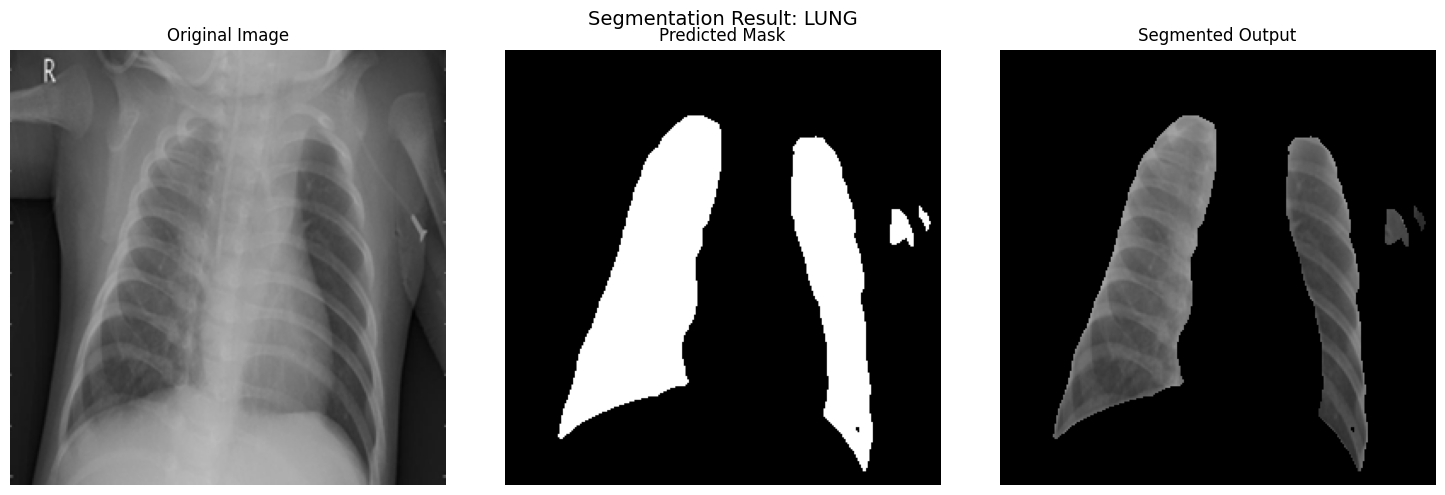

Time taken: 2.25 seconds
Pipeline Result: {'classification_viralpneumonia': {'prompt': 'Assess for viral etiology pneumonia. Upon confirmation, segment pulmonary structures for severity quantification.', 'prediction': 'Viralpneumonia', 'confidence': 1.0, 'predicted_class': 'Viralpneumonia'}, 'segmentation_lung': {'original_image': array([[[45, 45, 45],
        [43, 43, 43],
        [44, 44, 44],
        ...,
        [32, 32, 32],
        [24, 24, 24],
        [39, 39, 39]],

       [[45, 45, 45],
        [43, 43, 43],
        [44, 44, 44],
        ...,
        [34, 34, 34],
        [30, 30, 30],
        [38, 38, 38]],

       [[46, 46, 46],
        [44, 44, 44],
        [44, 44, 44],
        ...,
        [36, 36, 36],
        [35, 35, 35],
        [40, 40, 40]],

       ...,

       [[20, 20, 20],
        [22, 22, 22],
        [24, 24, 24],
        ...,
        [29, 29, 29],
        [27, 27, 27],
        [26, 26, 26]],

       [[25, 25, 25],
        [25, 25, 25],
        [24, 24, 24],


In [19]:
import time

# Start timer
start_time = time.time()

result = run_unified_pipeline(
    prompt = "Assess for viral etiology pneumonia. Upon confirmation, segment pulmonary structures for severity quantification.",
    image_path = "/kaggle/input/combined-dataset-pt1/C7_Covid19 Dataset/Test/Viral_Pneumonia/1.png",
)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")
print("Pipeline Result:", result)

# LLM Generated Response

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

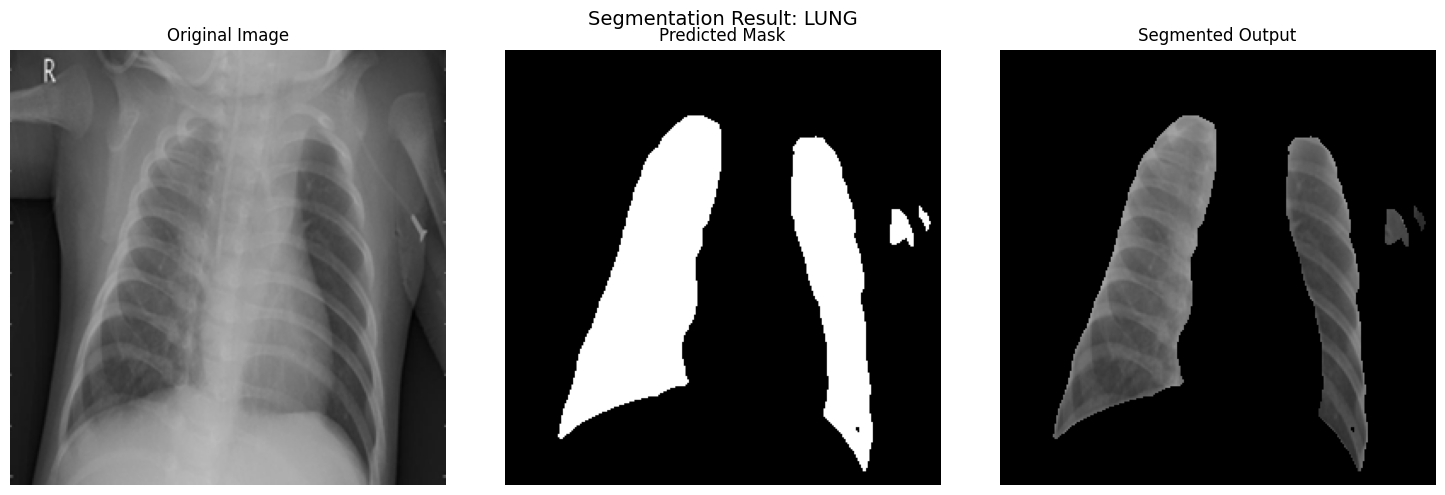

The patient has been diagnosed with viral pneumonia with 100% confidence, and the lung has been successfully segmented.
Time taken for Output Generation: 2.88 seconds
Time taken for Final Response: 23.09 seconds


In [20]:
import contextlib
import io
import time

start_time = time.time()
start_time_1 = time.time()
with contextlib.redirect_stdout(io.StringIO()):
    result = run_unified_pipeline(
    prompt = "Assess for viral etiology pneumonia. Upon confirmation, segment pulmonary structures for severity quantification.",
    image_path = "/kaggle/input/combined-dataset-pt1/C7_Covid19 Dataset/Test/Viral_Pneumonia/1.png",
    )
end_time = time.time()
elapsed_time = end_time - start_time

summary_description = []

for key, val in result.items():
    if key.startswith("segmentation_"):
        target = key.replace("segmentation_", "").replace("_", " ").capitalize()
        summary_description.append(f"Segmented {target}.")
    elif key.startswith("classification_"):
        target = key.replace("classification_", "").replace("_", " ").capitalize()
        pred = val.get("prediction", "unknown")
        conf = val.get("confidence", None)
        if conf is not None:
            conf_pct = conf * 100
            summary_description.append(
                f"{target} classified as {pred} with confidence {conf_pct:.2f}%."
            )
        else:
            summary_description.append(f"{target} classified as {pred}.")


llm_prompt = f"""
You are a medical AI assistant. Based on the findings below, provide a concise and natural language clinical summary.
Refer back to the user's original request: "{prompt}"

Only respond with the summary—no JSON, no explanations, no extra text. Your answer must be consistent with the text.

Findings:
- {" ".join(summary_description)}

Output format:

📝 Clinical Summary:
"""

summary = llm.invoke(llm_prompt).content.strip()

# Optional: Remove any leading/trailing markdown or formatting
summary = summary.replace("📝 Clinical Summary:", "").strip()

print(summary)
print(f"Time taken for Output Generation: {elapsed_time:.2f} seconds")
end_time_1 = time.time()
elapsed_time_1 = end_time_1 - start_time_1
print(f"Time taken for Final Response: {elapsed_time_1:.2f} seconds")
